- Satheesh D M

- MA24M023

- Task 2 - CNN edge detector

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torchvision.models as models
import logging
import os
import csv
import numpy as np
import random
import torch.nn.functional as F
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
def set_seed(seed=42):
    """
    Set the seed for reproducibility in PyTorch, NumPy, and Python's random module on MPS.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # For MPS (Apple Silicon)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
        print("Seed set for MPS.")
    
    torch.use_deterministic_algorithms(True, warn_only=True)
        
    print(f"Seed set to: {seed}")

# Example Usage
set_seed(42)

Seed set for MPS.
Seed set to: 42


In [ ]:
class BSDS500(Dataset):
    def __init__(self, image_dir, edge_dir, transform=None, edge_transform=None):
        """
        Custom dataloader for BSDS500 edge detection dataset using JPG ground truth.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            edge_dir (str): Path to corresponding edge ground truth directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.edge_dir = edge_dir
        self.transform = transform
        self.edge_transform = edge_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Load Ground Truth Edge Image
        edge_path = os.path.join(self.edge_dir, img_name)
        edge_image = Image.open(edge_path).convert('L')

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.edge_transform:
            edge_image = self.edge_transform(edge_image)

        return image, edge_image

# Separate transforms
vgg_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

edge_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

g = torch.Generator()
g.manual_seed(42)

# Create Dataloaders
train_dataset = BSDS500(image_dir='archive/images/train', edge_dir='archive/ground_truth_boundaries/train',
                         transform=vgg_transform, edge_transform=edge_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, generator=g)

val_dataset = BSDS500(image_dir='archive/images/val', edge_dir='archive/ground_truth_boundaries/val',
                       transform=vgg_transform, edge_transform=edge_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0, generator=g)

In [ ]:
# CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class BalancedBCEWithLogitsLoss(nn.Module):
    def __init__(self):
        super(BalancedBCEWithLogitsLoss, self).__init__()

    def forward(self, pred, target):
        # Class balancing
        pos_count = torch.sum(target)
        neg_count = target.numel() - pos_count
        beta = neg_count / (pos_count + neg_count + 1e-6)

        weights = beta * target + (1 - beta) * (1 - target) + 1e-4
        loss = F.binary_cross_entropy_with_logits(pred, target, weight=weights)

        return loss

In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    # Check and set device
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    model.to(device)

    os.makedirs('checkpoints', exist_ok=True)
    csv_path = os.path.join('checkpoints', 'CNN.csv')
    
    # Create CSV and write headers
    with open(csv_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Train Loss", "Validation Loss"])
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        epoch_loss = 0
        for images, edges in train_loader:
            images, edges = images.to(device), edges.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, edges)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, edges in val_loader:
                images, edges = images.to(device), edges.to(device)

                outputs = model(images)
                loss = criterion(outputs, edges)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Save to CSV
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch+1, train_loss, val_loss])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Validation Loss: {val_loss}')
    
    return train_losses, val_losses

In [6]:
import torch.optim as optim
# Initialize model, criterion, and optimizer
model = CNN()
criterion = BalancedBCEWithLogitsLoss()
lrate = 0.001
optimizer = optim.Adam(model.parameters(), lr=lrate)

# Train and Validate
train_losses, val_losses = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

Epoch [1/100], Train Loss: 0.023817852282753356, Validation Loss: 0.021473737098276616
Epoch [2/100], Train Loss: 0.019473835467719115, Validation Loss: 0.017515031285583973
Epoch [3/100], Train Loss: 0.017447291515194453, Validation Loss: 0.016923963166773318
Epoch [4/100], Train Loss: 0.01712862430856778, Validation Loss: 0.01670920003205538
Epoch [5/100], Train Loss: 0.016703496758754436, Validation Loss: 0.016500063240528107
Epoch [6/100], Train Loss: 0.01682287325652746, Validation Loss: 0.0164274213463068
Epoch [7/100], Train Loss: 0.01646937050211888, Validation Loss: 0.016339521631598474
Epoch [8/100], Train Loss: 0.016548657646546, Validation Loss: 0.016329772770404816
Epoch [9/100], Train Loss: 0.01638561594658173, Validation Loss: 0.01625573992729187
Epoch [10/100], Train Loss: 0.0162973736341183, Validation Loss: 0.01620705094188452
Epoch [11/100], Train Loss: 0.016316692631405134, Validation Loss: 0.016208656951785087
Epoch [12/100], Train Loss: 0.016288446835600413, Valid

In [12]:
test_dataset = BSDS500(image_dir='archive/images/test', edge_dir='archive/ground_truth_boundaries/test',
                        transform=vgg_transform, edge_transform=edge_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True) 

def plot_results(model, dataloader, threshold=0.25, device='mps', num_batches=2):
    model.eval()  # Set the model to evaluation mode
    batch_count = 0
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, edges in dataloader:
            images = images.to(device)
            edges = edges.unsqueeze(1).to(device)  # Make sure the ground truth has the correct shape

            # Get the model's output and apply Sigmoid activation
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply Sigmoid

            # Apply thresholding to get binary predictions
            predictions = (outputs > threshold).float()

            # Visualize the results for the current batch
            for i in range(len(images)):
                plt.figure(figsize=(12, 4))
                
                # Display input image
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))  # Convert to HxWxC format for displaying
                plt.title("Input Image")

                # Display ground truth
                plt.subplot(1, 3, 2)
                plt.imshow(edges[i].cpu().squeeze(), cmap='gray')  # Remove channel dimension for grayscale image
                plt.title("Ground Truth")

                # Display predicted edges
                plt.subplot(1, 3, 3)
                plt.imshow(predictions[i].cpu().squeeze(), cmap='gray')  # Remove channel dimension
                plt.title("Predicted Edges")

                plt.show()

            batch_count += 1
            if batch_count >= num_batches:
                break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.4285715].


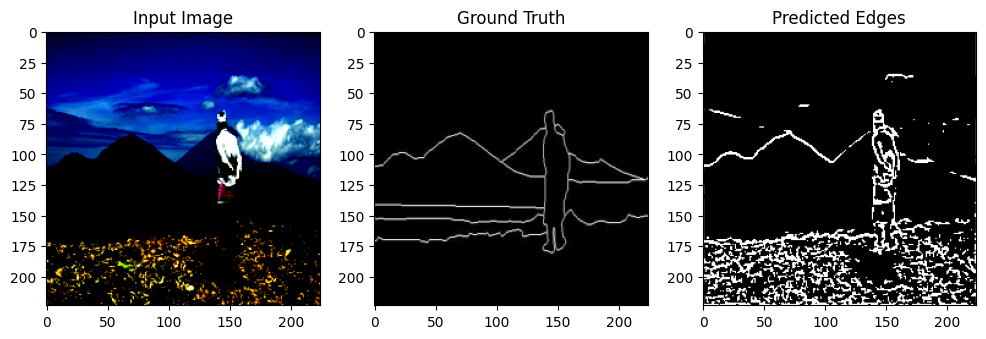

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].


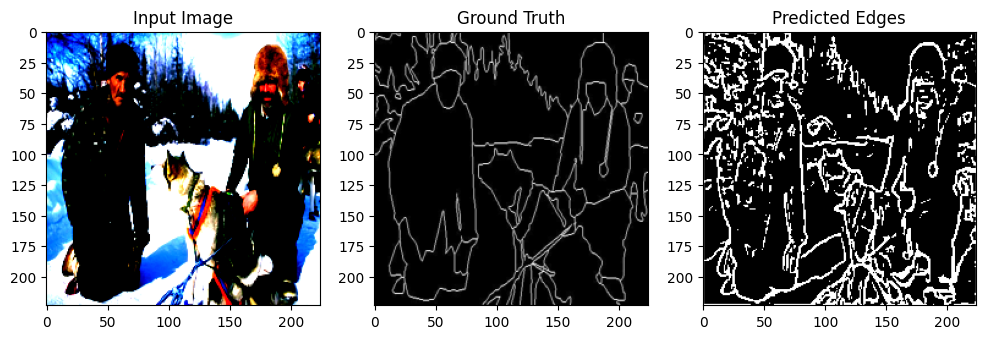

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7069099..2.5179958].


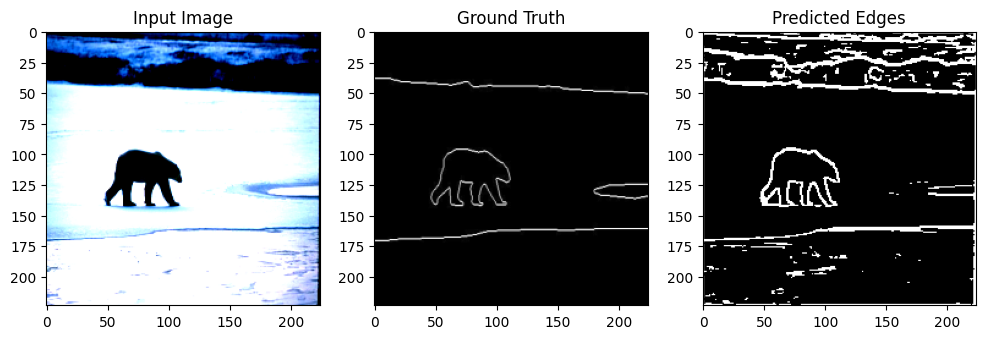

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4329139..2.6051416].


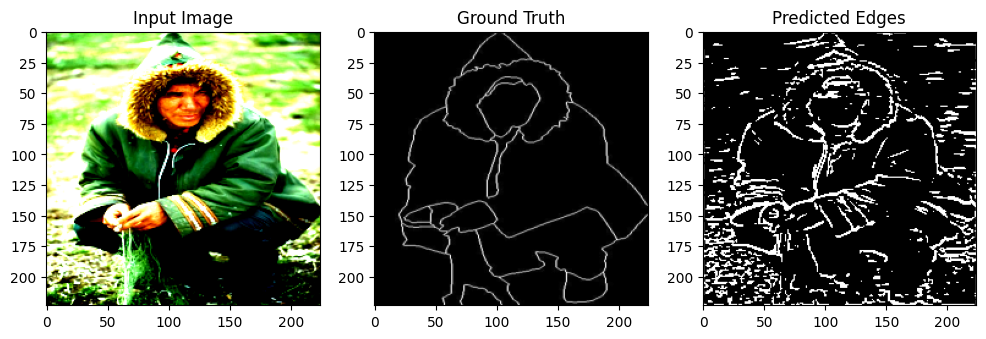

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.4110641].


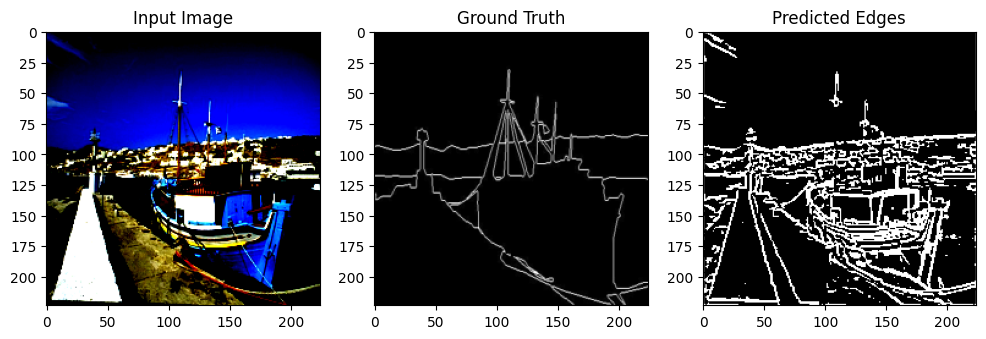

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.129035].


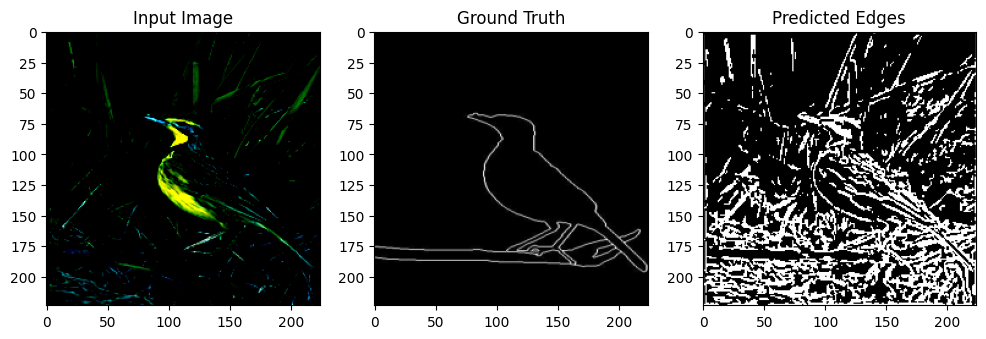

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.2146587].


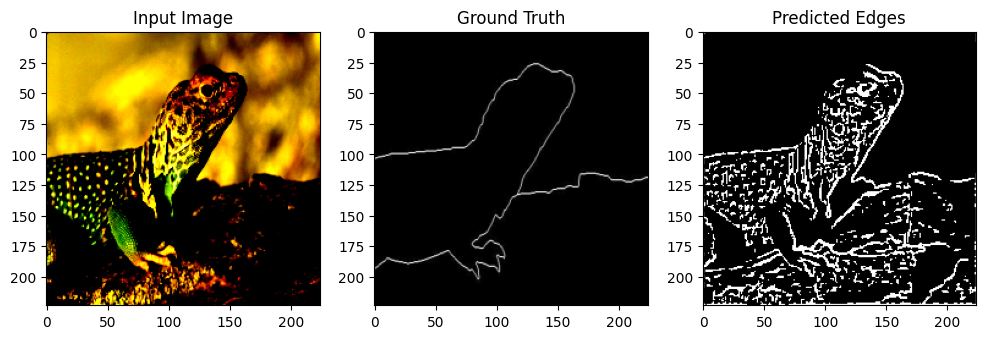

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].


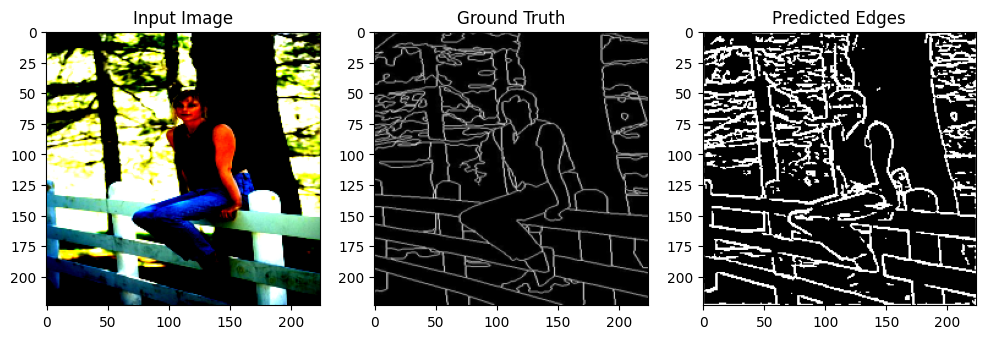

In [20]:
plot_results(model, test_loader, threshold=0.22, device='mps', num_batches=2)